In [1]:
import importlib
import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F

from utils import layers, hooking, img, stats, models, losses, shift
from stepping import loss, closure

In [2]:
vgg = models.vgg19()

In [3]:
hooker = hooking.Hooker(vgg)
hooker.attach_hooks("smooth_hooks", [1])
hooker.attach_hooks("texture_hooks", [3, 6, 19, 26, 37])
hook_bag = hooker.get_bag()
vgg = layers.clipped_model(vgg, hooker.last_hooked_index())

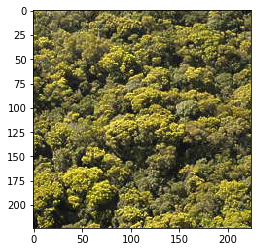

In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.ToTensor(),
])

example_texture = img.image_loader("data/original/trees.jpg", transform)
img.show_image(example_texture)

In [5]:
importlib.reload(losses)
importlib.reload(shift)

vgg(example_texture)
target = stats.extract_features(hook_bag.get_hook("texture_hooks"), stats.gram_matrix)

def texture_loss_fn(target_grams, sample_features):
    sample_grams = [stats.gram_matrix(feature) for feature in sample_features]
    loss = 0
    
    for i in range(len(sample_grams)):
        loss += F.mse_loss(sample_grams[i], target_grams[i]) / len(sample_grams)  
    
    loss *= 100000000
    print("texture loss: {}".format(loss))
    return loss 

texture_loss = loss.LossFn(target, hook_bag.get_hook("texture_hooks"), texture_loss_fn)

def smooth_loss(_, sample_features):
    loss = 0
    for layer in sample_features:
        loss += losses.smoothing_loss(layer) * layer.numel()
    
    loss *= 1000
    print("smooth loss: {}".format(loss))
    return loss 

smoothness_loss = loss.LossFn(None, hook_bag.get_hook("smooth_hooks"), smooth_loss) 

In [10]:
collector = loss.LossCollector()
#collector.add_loss_fn("texture", smoothness_loss)
collector.add_loss_fn("texture", texture_loss)

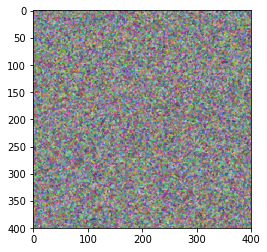

In [11]:
sample_texture = img.random_image(4, 400)
img.show_image(sample_texture)

inputs = {
    "input": sample_texture,
    "loss_name": "texture",
    "pyramid": False,
}

optimizer = optim.LBFGS([sample_texture])

In [12]:
stepper = closure.Stepper(inputs, vgg, collector, optimizer)

In [ ]:
importlib.reload(stats)
importlib.reload(losses)

show_at = 1
for i in range(32):
    optimizer.step(stepper.loss_fn)
    
    if i + 1 == show_at:
        show_at *= 2
        img.save_image(sample_texture, "data/synth/trees-unsmooth{}.jpg".format(show_at))
    print(sample_texture.grad[0][0][0][:3])

texture loss: 54358.58203125
texture loss: 54352.7421875
texture loss: 41212137472.0
texture loss: 53818.65234375
texture loss: 53294.69140625
texture loss: 35642.5078125
texture loss: 28040.634765625
texture loss: 26207.0859375
texture loss: 18453.55078125
texture loss: 16802.9140625
texture loss: 13293.6865234375
texture loss: 10260.3876953125
texture loss: 8803.4228515625
texture loss: 7473.71728515625
texture loss: 6969.2626953125
texture loss: 5860.64794921875
texture loss: 5374.1630859375
texture loss: 4681.85595703125
texture loss: 4318.83056640625
texture loss: 4058.357177734375
tensor([ 0.3254,  0.2838, -0.0729], device='cuda:0')
texture loss: 3731.657470703125
texture loss: 3245.46923828125
texture loss: 3099.21240234375
texture loss: 2941.66748046875
texture loss: 2752.6943359375
texture loss: 2549.538330078125
texture loss: 2309.8564453125
texture loss: 2244.819091796875
texture loss: 2134.259033203125
texture loss: 1970.0384521484375
texture loss: 1863.2623291015625
textur

texture loss: 21.980226516723633
tensor([-0.0090, -0.0032, -0.0175], device='cuda:0')
texture loss: 21.826248168945312
texture loss: 21.63324546813965
texture loss: 21.327402114868164
texture loss: 21.056550979614258
texture loss: 20.892475128173828
texture loss: 20.71514129638672
texture loss: 20.47882843017578
texture loss: 20.26921844482422
texture loss: 20.0559139251709
texture loss: 19.82131004333496
texture loss: 19.634624481201172
texture loss: 19.46435546875
texture loss: 19.307376861572266
texture loss: 19.156269073486328
texture loss: 18.834314346313477
texture loss: 18.6124267578125
texture loss: 18.48843765258789
texture loss: 18.360271453857422
texture loss: 18.23039436340332
texture loss: 18.021114349365234
tensor([ 0.0023, -0.0027, -0.0090], device='cuda:0')
texture loss: 17.75445556640625
texture loss: 17.572742462158203
texture loss: 17.48088836669922
texture loss: 17.291797637939453
texture loss: 17.086811065673828
texture loss: 16.891611099243164
texture loss: 16.749

texture loss: 4.350725173950195
texture loss: 4.338037967681885
texture loss: 4.326758861541748
texture loss: 4.313460350036621
texture loss: 4.290513515472412
tensor([-0.0009, -0.0056, -0.0065], device='cuda:0')
texture loss: 4.272954940795898
texture loss: 4.256679058074951
texture loss: 4.235867023468018
texture loss: 4.218883991241455
texture loss: 4.19882869720459
texture loss: 4.186399936676025
texture loss: 4.171898365020752
texture loss: 4.154765605926514
texture loss: 4.1381516456604
texture loss: 4.12079381942749
texture loss: 4.106997966766357
texture loss: 4.094717025756836
texture loss: 4.072903633117676
texture loss: 4.057186126708984
texture loss: 4.046220302581787
texture loss: 4.0348076820373535
texture loss: 4.020457744598389
texture loss: 4.001364231109619
texture loss: 3.9867312908172607
texture loss: 3.971353769302368
tensor([0.0001, 0.0082, 0.0061], device='cuda:0')
texture loss: 3.9593255519866943
texture loss: 3.9500019550323486
texture loss: 3.9376776218414307
